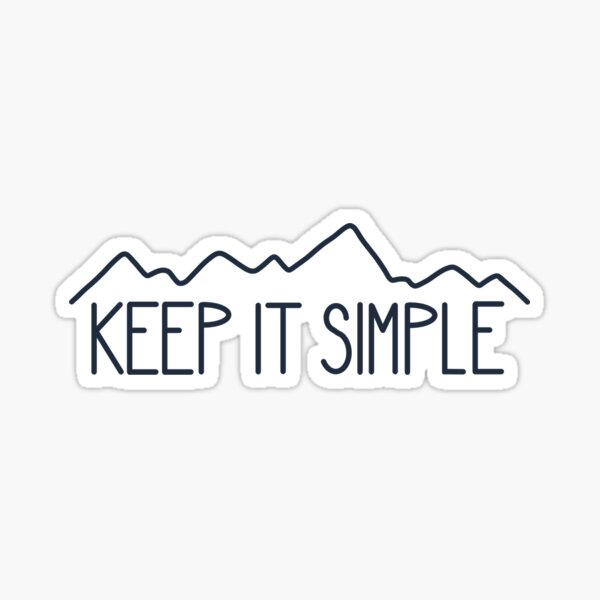

## Objective of this notebook
---
The objective of this notebook is to develop a baseline model for testing throughout the competition period. **Our aim is not to achieve a top position on the leaderboard but to focus on the code structure and the tools that can be used and adjusted in the future**. The chosen model will be the RandomForestRegressor, and only 500 samples of the data will be used to expedite training.

## Steps
---
1. Load Data
2. Modeling
    - Data Splitting (Sampling)
    - Model Definition
    - Pipeline Creation and Integration
    - Data Training
3. Model Evaluation
4. Submission

## Packages
---
Install the following packages in Python prior to running the code.

In [37]:
import pandas as pd
import numpy as np

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

## Load data
---

In [39]:
PATH_TRAIN = '/kaggle/input/playground-series-s4e5/train.csv'
PATH_TEST = '/kaggle/input/playground-series-s4e5/test.csv'
PATH_SAMPLE = '/kaggle/input/playground-series-s4e5/sample_submission.csv'
TARGET = 'FloodProbability'
SEED = 2024
SAMPLE = 5000
DATA_LOAD = pd.read_csv(PATH_TRAIN, index_col='id')
DATA_LOAD = DATA_LOAD.sample(SAMPLE)

## Modeling
---

In [43]:
# Data Splitting
X_data, y_data = DATA_LOAD.drop(TARGET, axis=1), DATA_LOAD[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.27)

# Define model parameters for tuning XGBRegressor
base_estimator = RandomForestRegressor(max_depth=2, random_state=SEED)
params = {}

# Create preprocessing pipeline
numeric_features = X_data.select_dtypes(exclude=['object']).columns
numeric_transformer = Pipeline(steps=[("scaler", PowerTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)])

# Combine preprocessing and classifier into one pipeline
clf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("classifier", base_estimator)])

# Train using cross-validation and grid search
cv = RepeatedKFold()
grid_search = GridSearchCV(clf_pipeline,
                           param_grid={},
                           scoring="r2", verbose=4,
                           cv=cv)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train);

Fitting 50 folds for each of 1 candidates, totalling 50 fits
[CV 1/50] END .................................., score=0.107 total time=   0.5s
[CV 2/50] END .................................., score=0.106 total time=   0.5s
[CV 3/50] END .................................., score=0.101 total time=   0.5s
[CV 4/50] END .................................., score=0.119 total time=   0.5s
[CV 5/50] END .................................., score=0.098 total time=   0.5s
[CV 6/50] END .................................., score=0.119 total time=   0.5s
[CV 7/50] END .................................., score=0.097 total time=   0.5s
[CV 8/50] END .................................., score=0.108 total time=   0.5s
[CV 9/50] END .................................., score=0.107 total time=   0.5s
[CV 10/50] END ................................., score=0.103 total time=   0.5s
[CV 11/50] END ................................., score=0.104 total time=   0.5s
[CV 12/50] END .................................

## Evaluate
---

In [41]:
def evaluation(X_train, y_train, X_val, y_val, grid_search):
    """
    Evaluate model performance on training and validation sets.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_val: Validation features
    - y_val: Validation labels
    - grid: Trained GridSearchCV model
    
    Returns:
    - DataFrame: Contains RMSLE scores for training and validation sets
    """
    # Evaluate on the validation set
    y_pred_val = grid_search.predict(X_val)
    rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))

    # Evaluate on the training set
    y_pred_train = grid_search.predict(X_train)
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    
    # Create DataFrame
    score_dict = {"on_train": rmsle_train, "on_test": rmsle_val}
    score_df = pd.DataFrame(score_dict, index=['Score']).T
    
    return score_df

# Call the function with appropriate arguments
evaluation(X_train, y_train, X_val, y_val, grid_search)

,Score
on_train,0.031668
on_test,0.033099


## Submit
---

In [42]:
# Load sample submission and test data
submission_df = pd.read_csv(PATH_SAMPLE)
test_df = pd.read_csv(PATH_TEST, index_col='id')

# Predict using the trained model and assign predictions to the submission DataFrame
submission_df['FloodProbability'] = grid_search.predict(test_df)

# Save the submission DataFrame to a CSV file
submission_df.to_csv('Make-It-Simple.csv', index=False)
submission_df.head(3)

,id,FloodProbability
0,1117957,0.516540
1,1117958,0.496684
2,1117959,0.498112


## Acknowledgements
---
CLL - [Analyzing the data](https://www.kaggle.com/code/carloscll/analyzing-the-data)